# Tracking de vehicles utilitzant YOLO

El tracking o seguiment d'objectes és una tasca de visió per computador que consisteix en seguir un objecte o una regió d'interès a través de diferents fotogrames d'un vídeo. Aquesta tasca és molt important en moltes aplicacions com la vigilància, la conducció autònoma, la realitat augmentada, etc.

Nosaltres utilitzarem YOLO (You Only Look Once) per detectar els objectes en cada fotograma i després utilitzarem ByteTrack per seguir-los. ByteTrack és un algoritme de seguiment d'objectes que utilitza la informació de la detecció per seguir els objectes a través dels fotogrames. ByteTrack és molt ràpid i eficient, i pot ser utilitzat en temps real.

## Carreguem les llibreries

Comencem instal·lant i carregant les llibreries necessàries per aquest notebook.


In [28]:
%pip install ultralytics requests opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [29]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

import cv2
import matplotlib.pyplot as plt

Ultralytics YOLOv8.1.37 🚀 Python-3.8.10 torch-2.2.2+cu121 CPU (12th Gen Intel Core(TM) i3-1215U)
Setup complete ✅ (8 CPUs, 15.3 GB RAM, 64.2/219.4 GB disk)


## Dades

Per aquest projecte no caldrà entrenar un model ja que utilitzarem un model pre-entrenat de YOLO amb el dataset COCO, que conté les classes de cotxes que necessitem. Si calgés podríem repetir el procés vist en la pràctica anterior per entrenar un model amb les nostres pròpies dades.

En primer lloc, carreguem el video que volem analitzar. En aquest cas, utilitzarem un video de cotxes en una autopista.

In [30]:
!wget https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/vehicle-counting.mp4

--2024-04-05 15:08:10--  https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/vehicle-counting.mp4
S'està resolent lawer.github.io (lawer.github.io)… 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
S'està connectant a lawer.github.io (lawer.github.io)|185.199.109.153|:443… connectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 200 OK
Mida: 35345757 (34M) [video/mp4]
S'està desant a: «vehicle-counting.mp4.1»

vehicle-counting.mp 100%[===================>]  33,71M  22,0MB/s    in 1,5s    

2024-04-05 15:08:14 (22,0 MB/s) - s'ha desat «vehicle-counting.mp4.1» [35345757/35345757]



In [31]:
SOURCE_VIDEO_PATH = "vehicle-counting.mp4"

## Carreguem el model YOLO

Seguirem els passos de la pràctica anterior per carregar el model YOLO. A continuació l'executem per a obtenir les deteccions dels cotxes en un fotograma del video.

In [32]:
model = YOLO("yolov8l.pt")

In [33]:
video = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Extraiem el primer frame del vídeo

success, frame = video.read()

In [34]:
# Detectem els objectes del frame

results = model(frame)

# Mostrem els resultats

for r in results:
    for box in r.boxes:
        print(f"Coordenades de la caixa: {box.xyxy}")
        print(f"Confiança: {box.conf}")
        print(f"Classe: {box.cls}")
        print()


0: 384x640 3 cars, 1 truck, 618.0ms
Speed: 4.9ms preprocess, 618.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Coordenades de la caixa: tensor([[2942.2930, 1271.7455, 3225.4299, 1497.0488]])
Confiança: tensor([0.9016])
Classe: tensor([2.])

Coordenades de la caixa: tensor([[ 937.3493,  895.1592, 1245.1067, 1305.0732]])
Confiança: tensor([0.8946])
Classe: tensor([7.])

Coordenades de la caixa: tensor([[1437.2089, 1086.9843, 1622.6614, 1228.1613]])
Confiança: tensor([0.7979])
Classe: tensor([2.])

Coordenades de la caixa: tensor([[1477.5365, 1006.3534, 1630.9124, 1137.9227]])
Confiança: tensor([0.6360])
Classe: tensor([2.])



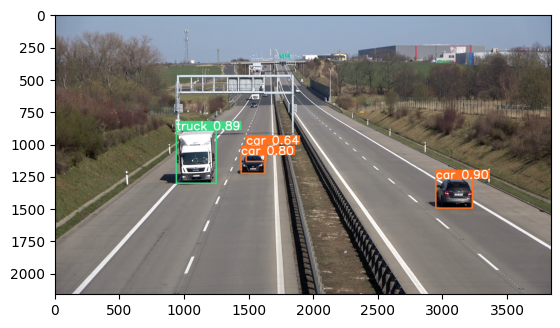

In [35]:
# Visualitzem el frame amb les caixes dels objectes detectats

for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

Els resultats son prou bons, per lo que podem continuar amb el seguiment dels cotxes.

## Seguiment de vehicles

Per fer el seguiment de vehicles utilitzarem el tracker ByteTrack. Anirem fotograma per fotograma i per cada fotograma actualitzarem el tracker amb les noves deteccions. Això ens permetrà seguir els vehicles a través del video.

In [36]:

video_in = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Llegim el primer frame del vídeo
success, frame = video_in.read()

# Creem un objecte per escriure el vídeo en format MP4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter("cotxes.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]))

while video_in.isOpened():
    success, frame = video_in.read()

    if success:
        # Utilitzem persist=True per mantenir la identitat dels objectes
        results = model.track(frame, persist=True, tracker="bytetrack.yaml")

        # Creem el frame amb les caixes dels objectes detectats
        sortida = results[0].plot()

        # Escrivim el frame al vídeo de sortida
        video_out.write(sortida)
    else:
        break

# Alliberem els recursos
video_in.release()
video_out.release()



0: 384x640 2 cars, 1 truck, 590.4ms
Speed: 8.8ms preprocess, 590.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 638.6ms
Speed: 21.9ms preprocess, 638.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 584.0ms
Speed: 2.1ms preprocess, 584.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 578.2ms
Speed: 21.4ms preprocess, 578.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 595.8ms
Speed: 3.3ms preprocess, 595.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 624.9ms
Speed: 8.3ms preprocess, 624.9ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 543.5ms
Speed: 3.0ms preprocess, 543.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 544.5ms
Speed: 2.5ms pre

El resultat el tenim en [`cotxes.mp4`](https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/cotxes_comprimit.mp4) que podem descarregar i visualitzar.

## Dibuixem el seguiment

Com a exemple del que es pot fer en el seguiment, dibuixarem una estela dels vehicles en el video. Això ens permetrà veure com es mouen els vehicles al llarg del video.

In [37]:

from collections import defaultdict
import numpy as np

video_in = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Llegim el primer frame del vídeo
success, frame = video_in.read()

# Creem un objecte per escriure el vídeo en format MP4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter("cotxes_estela.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]))

track_history = defaultdict(lambda: [])

while video_in.isOpened():
    success, frame = video_in.read()

    if success:
        # Utilitzem persist=True per mantenir la identitat dels objectes
        results = model.track(frame, persist=True, tracker="bytetrack.yaml")

        # Creem el frame amb les caixes dels objectes detectats
        sortida = results[0].plot()

        try:
            boxes = results[0].boxes.xywh.cpu() # obtenim les caixes dels objectes detectats en format (x, y, w, h) 
                                                # x, y és la cantonada superior esquerra de la caixa, 
                                                # w, h és l'amplada i l'altura
            track_ids = results[0].boxes.id.int().cpu().tolist()

            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y))) # agreguem el punt (x, y) al track
                if len(track) > 30:  # restringim la longitud del track a 30 punts
                    track.pop(0)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(sortida, [points], isClosed=False, color=(230, 230, 230), thickness=10)

        except Exception as e:
            print(e)

        # Escrivim el frame al vídeo de sortida
        video_out.write(sortida)
    else:
        break

# Alliberem els recursos
video_in.release()
video_out.release()


0: 384x640 4 cars, 2 trucks, 606.6ms
Speed: 5.4ms preprocess, 606.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
'NoneType' object has no attribute 'int'

0: 384x640 2 cars, 1 truck, 595.8ms
Speed: 2.0ms preprocess, 595.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 577.0ms
Speed: 22.0ms preprocess, 577.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 590.8ms
Speed: 2.1ms preprocess, 590.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 663.3ms
Speed: 3.4ms preprocess, 663.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 632.2ms
Speed: 3.1ms preprocess, 632.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 588.3ms
Speed: 2.3ms preprocess, 588.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 

El resultat el tenim en [`cotxes_estela.mp4`](https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/cotxes_estela_comprimit.mp4) que podem descarregar i visualitzar.

## Contar vehicles

Finalment, podem utilitzar el seguiment per comptar els vehicles que passen per una línia. Per fer-ho, simplement comprovarem si un vehicle ha passat per la línia en cada fotograma i incrementarem el comptador.

Si utilitzem `object_counter` per crear una linia horitzontal a la meitat del video, podem comptar els vehicles que passen per aquesta linia. Ademés es simplifica el codi anterior; a canvi de menys flexibilitat.

El resultat el tenim en [`cotxes_comptats.mp4`](https://lawer.github.io/mia/apunts/8.-Reconeixement%20imatges/cotxes_comptats_comprimit.mp4) que podem descarregar i visualitzar.

In [38]:
from ultralytics.solutions import object_counter

video_in = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# Llegim el primer frame del vídeo
success, frame = video_in.read()

# Creem un objecte per escriure el vídeo en format MP4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter("cotxes_comptats.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]))

# Definim les línies de comptatge
line = [(0, 1500), (3800, 1500)]

# Creem un objecte ObjectCounter
counter = object_counter.ObjectCounter()
counter.set_args(reg_pts=line,
                line_thickness=8,
                count_txt_thickness=8,
                classes_names=model.names,
                draw_tracks=True,
                track_thickness=8)

track_history = defaultdict(lambda: [])

while video_in.isOpened():
    success, frame = video_in.read()
    
    if success:
        # Utilitzem persist=True per mantenir la identitat dels objectes
        results = model.track(frame, persist=True, show=False, tracker="bytetrack.yaml")

        # Actualitzem el comptador amb els resultats de la detecció
        # També obtenim el frame amb les caixes dels objectes detectats i els tracks dibuixats
        sortida = counter.start_counting(frame, results)

        # Escrivim el frame al vídeo de sortida
        video_out.write(sortida)
    else:
        break

# Alliberem els recursos
video_in.release()
video_out.release()


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.8.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

Line Counter Initiated.

0: 384x640 4 cars, 2 trucks, 666.2ms
Speed: 7.5ms preprocess, 666.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 589.2ms
Speed: 2.4ms preprocess, 589.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 651.8ms
Speed: 1.7ms preprocess, 651.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 586.6ms
Speed: 2.0ms preprocess, 586.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 603.3ms
Spee